# Get Chili's locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import os
import requests
import json

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
import us

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

---

## Scrape

#### Headers for requests

In [4]:
headers = {
    "Connection": "keep-alive",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",
}

#### Make a list of state URLs

In [5]:
states = [
    "Alabama",
    "Alaska",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "Florida",
    "Georgia",
    "Hawaii",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "North Dakota",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Vermont",
    "Virginia",
    "Washington",
    "West Virginia",
    "Wisconsin",
    "Wyoming",
]

In [6]:
state_urls = []
for s in tqdm(states):
    state_urls.append(f"https://chilis.com/locations/us/{s.lower().replace(' ', '-')}")

  0%|          | 0/50 [00:00<?, ?it/s]

#### Loop through state urls and collect cities with restaurants and their respective URLs

In [7]:
state_responses = []
cities = []

for sr in tqdm(state_urls):
    state_response = requests.get(sr, headers=headers)
    state_soup = BeautifulSoup(state_response.text, "html.parser")
    state_data = state_soup.findAll("a", class_="top-locations-link")
    for sd in state_data:
        cities_dict = {
            "city_url": f'https://chilis.com{sd["href"]}',
            "city_name": sd["href"]
            .replace("locations/us/", "")
            .replace(sr.replace("https://chilis.com/locations/us/", ""), "")
            .title()
            .replace("//", ""),
            "state_name": sr.replace("https://chilis.com/locations/us/", "").title(),
        }
        cities.append(cities_dict)

  0%|          | 0/50 [00:00<?, ?it/s]

#### Each city page has a list of cities in that area, with links to location detail pages

In [8]:
city_details = []

for s in tqdm(cities):
    city_response = requests.get(s["city_url"], headers=headers)
    city_soup = BeautifulSoup(city_response.text, "html.parser")
    city_data = city_soup.findAll("a", class_="details-btn")
    for cd in city_data:
        city_data_dict = {
            "city_detail_url": cd["href"],
        }
        city_details.append(city_data_dict)

  0%|          | 0/1023 [00:00<?, ?it/s]

#### Make a dataframe from the detail page URLs

In [9]:
city_details_df = pd.DataFrame(city_details).drop_duplicates().reset_index(drop=True)

In [10]:
city_details_df["city_detail_url"] = (
    "https://chilis.com/" + city_details_df["city_detail_url"]
)

#### Scrape detail pages, grabbing inline json to populate location info

In [11]:
city_details_urls = city_details_df["city_detail_url"].to_list()

In [12]:
det_data_list = []

for det in tqdm(city_details_urls):
    det_response = requests.get(det, headers=headers)
    det_soup = BeautifulSoup(det_response.text, "html.parser")
    data = json.loads(det_soup.findAll("script", type="application/ld+json")[1].text)
    det_data_dict = {
        "brand": data["brand"],
        "location_name": data["name"],
        "phone": data["telephone"],
        "street": data["address"]["streetAddress"],
        "city": data["address"]["addressLocality"],
        "state": data["address"]["addressRegion"],
        "zip": data["address"]["postalCode"],
        "latitude": data["geo"]["latitude"],
        "longitude": data["geo"]["longitude"],
        "url": data["url"],
    }
    det_data_list.append(det_data_dict)

  0%|          | 0/1231 [00:00<?, ?it/s]

#### Dataframe of all locations

In [13]:
df = pd.DataFrame(det_data_list)

In [14]:
df["state_name"] = (
    df["url"].str.split("/", expand=True)[5].str.title().str.replace("-", " ")
)

In [15]:
df.head()

,brand,location_name,phone,street,city,state,zip,latitude,longitude,url,state_name
0,Chili's,Trussville,(205) 661-6102,1676 Gadsden Highway,Birmingham,AL,35235,33.602777,-86.638296,https://www.chilis.com/locations/us/alabama/birmingham/trussville/,Alabama
1,Chili's,Fultondale,(205) 849-4474,203 Howell St.,Fultondale,AL,35068,33.607654,-86.807505,https://www.chilis.com/locations/us/alabama/fultondale/fultondale/,Alabama
2,Chili's,Lakeshore,(205) 942-3129,209 State Farm Pkwy.,Homewood,AL,35209,33.447690,-86.825067,https://www.chilis.com/locations/us/alabama/homewood/lakeshore/,Alabama
3,Chili's,Decatur,(256) 355-8850,1003 Beltline Road SW,Decatur,AL,35601,34.559764,-87.005591,https://www.chilis.com/locations/us/alabama/decatur/decatur/,Alabama
4,Chili's,Madison,(256) 382-0950,8628 Highway 72 W,Madison,AL,35758,34.748304,-86.774186,https://www.chilis.com/locations/us/alabama/madison/madison/,Alabama


In [16]:
df.tail()

,brand,location_name,phone,street,city,state,zip,latitude,longitude,url,state_name
1226,Chili's,Plover,(715) 295-0156,165 Crossroads Drive,Plover,WI,54467,44.496180,-89.514434,https://www.chilis.com/locations/us/wisconsin/plover/plover/,Wisconsin
1227,Chili's,Kohler,(920) 453-9580,4001 Highway 28,Sheboygan Falls,WI,53085,43.716840,-87.763424,https://www.chilis.com/locations/us/wisconsin/sheboygan-falls/kohler/,Wisconsin
1228,Chili's,Cheyenne,(307) 635-1224,1320 Del Range Blvd.,Cheyenne,WY,82009,41.160856,-104.808345,https://www.chilis.com/locations/us/wyoming/cheyenne/cheyenne/,Wyoming
1229,Chili's,Casper,(307) 459-2727,510 E. Lathrop Rd,Evansville,WY,82636,42.856408,-106.269740,https://www.chilis.com/locations/us/wyoming/evansville/casper/,Wyoming
1230,Chili's,Laramie,(307) 745-3540,2523 Grand Ave,Laramie,WY,82070,41.309376,-105.559994,https://www.chilis.com/locations/us/wyoming/laramie/laramie/,Wyoming


#### Fix [two](https://www.chilis.com/locations/us/new-jersey/montclair/montclair-university/) [locations](https://www.chilis.com/locations/us/florida/miami/florida-intl-university/) with bad lon/lat on the page

In [17]:
df.loc[df["location_name"] == "Florida Intl University", "latitude"] = 25.7562861
df.loc[df["location_name"] == "Florida Intl University", "longitude"] = -80.3723177
df.loc[df["location_name"] == "Montclair University", "latitude"] = 40.859758
df.loc[df["location_name"] == "Montclair University", "longitude"] = -74.199745

---

## Analysis

#### Which states have the most locations?

In [18]:
state_counts = (
    df.groupby(["state_name", "state"])["location_name"]
    .count()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

In [19]:
state_counts.head(8)

,state_name,state,count
41,Texas,TX,218
8,Florida,FL,138
4,California,CA,108
12,Illinois,IL,50
32,North Carolina,NC,47
9,Georgia,GA,46
40,Tennessee,TN,37
5,Colorado,CO,34


#### What about if we normalize for population?

In [20]:
state_fips_codes = [
    {"state": "Alabama", "fips_code": "01"},
    {"state": "Alaska", "fips_code": "02"},
    {"state": "Arizona", "fips_code": "04"},
    {"state": "Arkansas", "fips_code": "05"},
    {"state": "California", "fips_code": "06"},
    {"state": "Colorado", "fips_code": "08"},
    {"state": "Connecticut", "fips_code": "09"},
    {"state": "Delaware", "fips_code": "10"},
    {"state": "Florida", "fips_code": "12"},
    {"state": "Georgia", "fips_code": "13"},
    {"state": "Hawaii", "fips_code": "15"},
    {"state": "Idaho", "fips_code": "16"},
    {"state": "Illinois", "fips_code": "17"},
    {"state": "Indiana", "fips_code": "18"},
    {"state": "Iowa", "fips_code": "19"},
    {"state": "Kansas", "fips_code": "20"},
    {"state": "Kentucky", "fips_code": "21"},
    {"state": "Louisiana", "fips_code": "22"},
    {"state": "Maine", "fips_code": "23"},
    {"state": "Maryland", "fips_code": "24"},
    {"state": "Massachusetts", "fips_code": "25"},
    {"state": "Michigan", "fips_code": "26"},
    {"state": "Minnesota", "fips_code": "27"},
    {"state": "Mississippi", "fips_code": "28"},
    {"state": "Missouri", "fips_code": "29"},
    {"state": "Montana", "fips_code": "30"},
    {"state": "Nebraska", "fips_code": "31"},
    {"state": "Nevada", "fips_code": "32"},
    {"state": "New Hampshire", "fips_code": "33"},
    {"state": "New Jersey", "fips_code": "34"},
    {"state": "New Mexico", "fips_code": "35"},
    {"state": "New York", "fips_code": "36"},
    {"state": "North Carolina", "fips_code": "37"},
    {"state": "North Dakota", "fips_code": "38"},
    {"state": "Ohio", "fips_code": "39"},
    {"state": "Oklahoma", "fips_code": "40"},
    {"state": "Oregon", "fips_code": "41"},
    {"state": "Pennsylvania", "fips_code": "42"},
    {"state": "Rhode Island", "fips_code": "44"},
    {"state": "South Carolina", "fips_code": "45"},
    {"state": "South Dakota", "fips_code": "46"},
    {"state": "Tennessee", "fips_code": "47"},
    {"state": "Texas", "fips_code": "48"},
    {"state": "Utah", "fips_code": "49"},
    {"state": "Vermont", "fips_code": "50"},
    {"state": "Virginia", "fips_code": "51"},
    {"state": "Washington", "fips_code": "53"},
    {"state": "West Virginia", "fips_code": "54"},
    {"state": "Wisconsin", "fips_code": "55"},
    {"state": "Wyoming", "fips_code": "56"},
]

#### Get population totals

In [21]:
base_url = "https://api.census.gov/data/2021/pep/population"
data_list = []

for state_info in state_fips_codes:
    # Construct the API URL for the current state
    api_url = f"{base_url}?get=NAME,POP_2021&for=state:{state_info['fips_code']}"

    response = requests.get(api_url)

    if response.status_code == 200:
        # Parse the JSON response
        result = response.json()

        data_list.append(result[1])

data_list.insert(0, ["state_name", "state_pop", "state_fips"])

In [22]:
pop_df = pd.DataFrame(data_list[1:], columns=data_list[0])

In [23]:
state_counts_pop = pd.merge(state_counts, pop_df, on="state_name")

In [24]:
state_counts_pop["rate_million"] = (
    (state_counts_pop["count"] / state_counts_pop["state_pop"].astype(int)) * 1000000
).round(2)

In [25]:
state_counts_pop.sort_values("rate_million", ascending=False).head()

,state_name,state,count,state_pop,state_fips,rate_million
19,New Mexico,NM,19,2115877,35,8.98
8,Oklahoma,OK,34,3986639,40,8.53
0,Texas,TX,218,29527941,48,7.38
11,Louisiana,LA,31,4624047,22,6.70
1,Florida,FL,138,21781128,12,6.34


In [26]:
state_counts_pop.sort_values("rate_million", ascending=False).tail()

,state_name,state,count,state_pop,state_fips,rate_million
44,Maine,ME,2,1372247,23,1.46
46,Alaska,AK,1,732673,02,1.36
45,North Dakota,ND,1,774948,38,1.29
48,Delaware,DE,1,1003384,10,1.00
47,Washington,WA,1,7738692,53,0.13


---

## Geography

#### Geodataframe from lon/lat

In [27]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

#### Plot it

<AxesSubplot: >

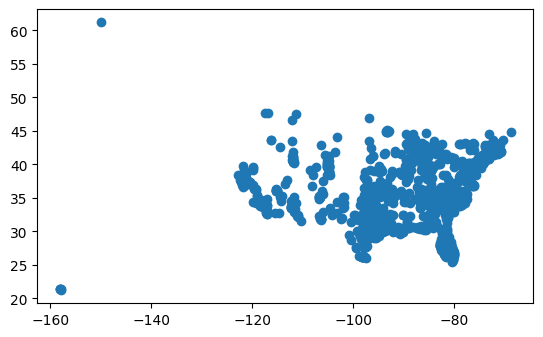

In [28]:
gdf.plot()

In [29]:
df = df.drop(["geometry"], axis=1)

---

## Exports

In [30]:
gdf.to_file("data/processed/chilis_locations.geojson", driver="GeoJSON")

In [31]:
df.to_json("data/processed/chilis_locations.json", orient="records", indent=4)

In [32]:
df.to_csv("data/processed/chilis_locations.csv", index=False)